#### What is Regression

Its when you want to predict a **continuous** value, not a discrete label.

In [12]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape) #404 train samples, containing 13 features, each of them is in different scale!
print(test_data.shape)  #102 test samples
print(train_targets.shape)    #median values of homes in thousands of dollars

(404, 13)
(102, 13)
(404,)


In [14]:
#normalizinge the input features, take mean of each column, subtract it from each feature and divide by std deviation of each column
#now each feature is centered around 0 and has unit std deviation
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# !!!normalizing the test data should be done with values calculated for train data!!!
test_data -= mean
test_data /= std

In [20]:
from keras import models
from keras import layers

# function for later use of building a model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1)) # no activation function, this will give us a linear output, typical setup for scalar regression
    model.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae']) # mse is 'mean squared error', oftenly used for regression problems, 
                                                                        # mae is 'mean absolute error', difference between the prediction and target
    return model



### K-fold validation
You use it when you dont have a lot of data, as in this example.

Previously the data was splitted into training set and validation set but now it cant be dont, for example they would be too different from each other

So you split data into K partitions (folds), and train on K-1 and validate one the remaining one. You make K models, each having different val and test set
Then the validation score for the model is the average of K validation scores

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size=16, verbose=0, validation_data=(val_data, val_targets)) #verbose=0 doesnt print during training
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    mae_history = history.history['val_mae']
    
    all_scores.append(val_mae)
    all_mae_histories.append(mae_history)

In [38]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

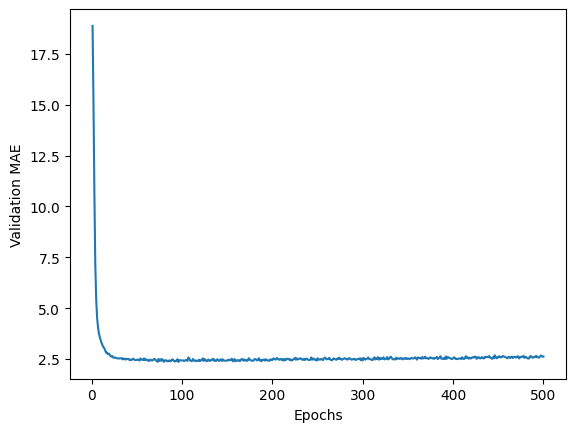

In [39]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

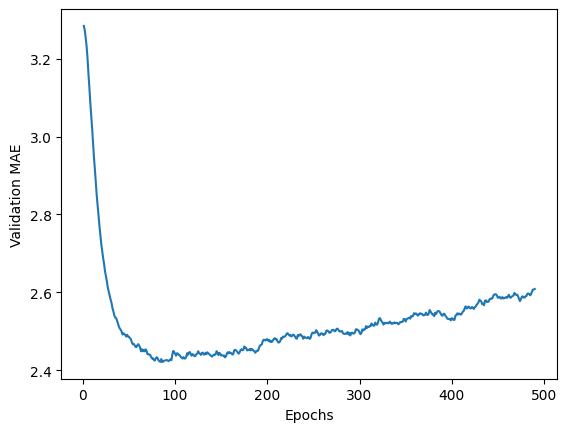

In [40]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [41]:
# training on entire data
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 22.1760 - mae: 2.8284


In [42]:
test_mae_score # we are off by 2820 dolars, not bad

2.8283934593200684